# Project - First Requirement

### Include packages.

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, norm    # Just to plot distribution of valuations

### The first thing to do is to code the environment.

In [147]:
class Environment:
    def __init__(self):
        pass
    def round(self, a_t):
        pass

### In this setting, the environment is responsible for telling the seller about the reward.

In [148]:
class PricingEnvironmentSingleProduct:
    def __init__(self, valuations, cost):
        self.valuations = valuations
        self.cost = cost

    def round(self, p_t):
        num_of_sales = np.sum(self.valuations >= p_t)       # Count how many customers are willing to pay at least p_t
        reward = (p_t - self.cost) * num_of_sales           # Count the profit subtracting the cost from the price for each sale
        return num_of_sales, reward

### Now define the setting...

In [ ]:
# --- Setting - Things that the seller needs to know --- #

min_p = 0                                   # Minimum price in euro
max_p = 5                                   # Maximum price in euro

T = 10000                                                           # Number of rounds
N = 1                                                               # Number of products
P = np.linspace(min_p, max_p, int((max_p - min_p) / 0.5) + 1)       # Prices from min_p to max_p inclusive, stepping by 0.5
B = 20000                                                           # Number of buyers

# --- Setting - Things that the environment needs to know --- #

num_of_buyers = ( int ) ( B / T * 50 )                                          # Assuming I can sell on average B / T * 50 items per round
assert not num_of_buyers < 1, "Number of buyers must be greater than 0"         # Assert that the number of buyers is greater than 0
value = 3.00                                                                    # "Real value" of the product
cost = 2.00                                                                     # Cost of the product
assert cost < value, "Cost must be less than the value of the product"          # Assert that cost is less than value
valuations = np.random.normal(loc=value, scale=1.0, size=num_of_buyers)         # Generate random valuations around 3.50€

# --- Setting - Things that the environment needs to know --- #

n_trials = 100                                                    # Number of trials to run for empirical regret resultsxxs

# --- Setting - Define the environment --- #

env = PricingEnvironmentSingleProduct(valuations=valuations, cost=cost)

### Expected demand and profit using theoretical expectations.

In [150]:
# In our setting, customer valuations are drawn from a normal distribution.
# Given this assumption, we can analytically compute the expected demand at each price p.
# It can be proven that the expected demand is given by: 

def expected_demand(p):
    return np.sum(1 - norm.cdf(p, loc=np.full(num_of_buyers, value), scale=1.0))

# This results in a smooth probability-based estimation of demand for each price p,
# where the probability for a single customer to buy is the tail area of the normal distribution beyond p.

expected_demand_vector = np.array([expected_demand(p) for p in P])
expected_profit_vector = (P - cost) * expected_demand_vector

best_index = np.argmax(expected_profit_vector)
best_price = P[best_index]
best_profit = expected_profit_vector[best_index]

### Realized demand and profit based on sampled valuations.

In [151]:
# Here we show the demand curve after drawing the customers evaluations.

def realized_demand(p):
    return np.sum(valuations >= p)

realized_demand_vector = np.array([realized_demand(p) for p in P])
realized_profit_vector = (P - cost) * realized_demand_vector

best_realized_index = np.argmax(realized_profit_vector)
best_realized_price = P[best_realized_index]
best_realized_profit = realized_profit_vector[best_realized_index]

### Let us visualize our setting.

Max expected profit (theoretical): 50.0
...at price: 3.0
Max realized profit (empirical): 52.5
...at price: 3.5


/var/folders/zn/rf3j_pdd4_d02m04l2_1fjcw0000gn/T/ipykernel_23459/3713412014.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend()


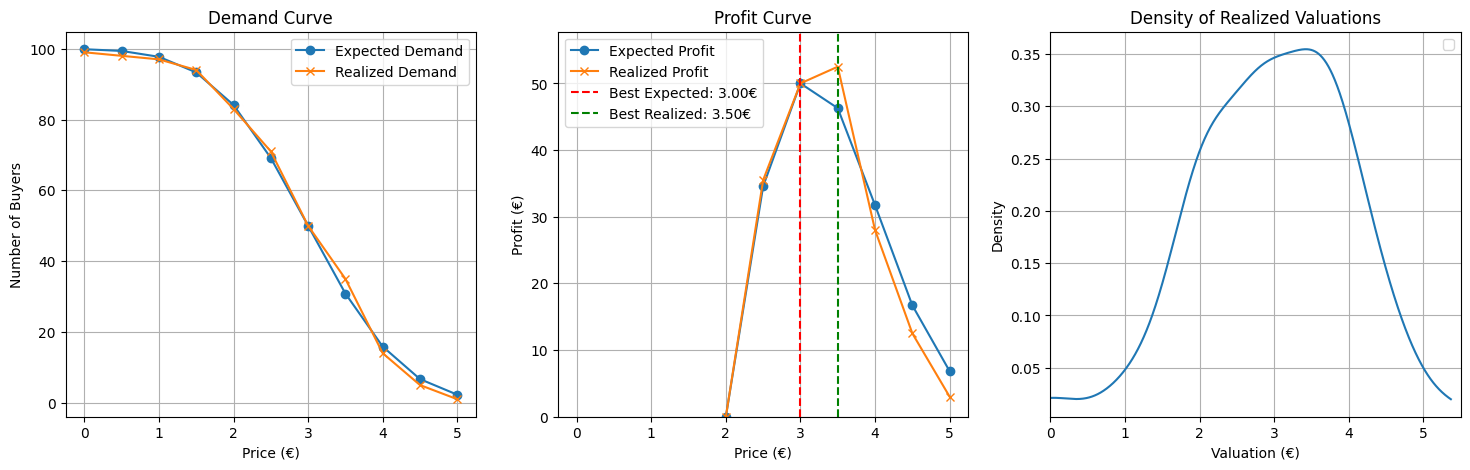

In [152]:
# --- Summary of Results ---

print("Max expected profit (theoretical):", round(best_profit, 2))
print("...at price:", round(best_price, 2))

print("Max realized profit (empirical):", round(best_realized_profit, 2))
print("...at price:", round(best_realized_price, 2))

# --- Plots: Expected vs Realized Demand and Profit ---

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Demand comparison
axs[0].plot(P, expected_demand_vector, label='Expected Demand', marker='o')
axs[0].plot(P, realized_demand_vector, label='Realized Demand', marker='x')
axs[0].set_title("Demand Curve")
axs[0].set_xlabel("Price (€)")
axs[0].set_ylabel("Number of Buyers")
axs[0].legend()
axs[0].grid(True)

# Profit comparison
axs[1].plot(P, expected_profit_vector, label='Expected Profit', marker='o')
axs[1].plot(P, realized_profit_vector, label='Realized Profit', marker='x')
axs[1].axvline(best_price, color='r', linestyle='--', label=f"Best Expected: {best_price:.2f}€")
axs[1].axvline(best_realized_price, color='g', linestyle='--', label=f"Best Realized: {best_realized_price:.2f}€")
axs[1].set_title("Profit Curve")
axs[1].set_xlabel("Price (€)")
axs[1].set_ylabel("Profit (€)")
axs[1].legend()
axs[1].grid(True)
# Automatically adjust y-axis to show just above the lowest observed positive profit
positive_profits = np.concatenate([expected_profit_vector, realized_profit_vector])
ymin = max(min(positive_profits[positive_profits > 0].min(), 0), 0)
ymax = positive_profits.max() * 1.1  # a bit of margin on top
axs[1].set_ylim(ymin, ymax)

# KDE of sampled valuations
x_vals = np.linspace(min(valuations), max(valuations), 1000)
axs[2].plot(x_vals, gaussian_kde(valuations)(x_vals))
axs[2].set_xlim(min_p, max_p*1.1)
axs[2].set_title("Density of Realized Valuations")
axs[2].set_xlabel("Valuation (€)")
axs[2].set_ylabel("Density")
axs[2].legend()
axs[2].grid(True)

### How can I interact with this environment? We use Agents.

In [153]:
class Agent:
    def __init__(self):
        pass
    def pull_arm(self):
        pass
    def update(self, r_t):
        pass

### UCB1 Agent.

In [154]:
# If rewards lie in [0, R], you must scale the confidence term by self.range = R maximum possible reward in a round t.

class UCB1Agent:
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        if self.t < self.K: # In the first K rounds, we sample each arm once
            self.a_t = self.t
        else:   
            ucbs = self.average_rewards + self.range * np.sqrt( 2 * np.log(self.T) / self.N_pulls )
            self.a_t = np.argmax(ucbs)
        return self.a_t

    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += ( r_t - self.average_rewards[self.a_t] ) / self.N_pulls[self.a_t]
        self.t += 1

### Cumulative Regret of UCB1.

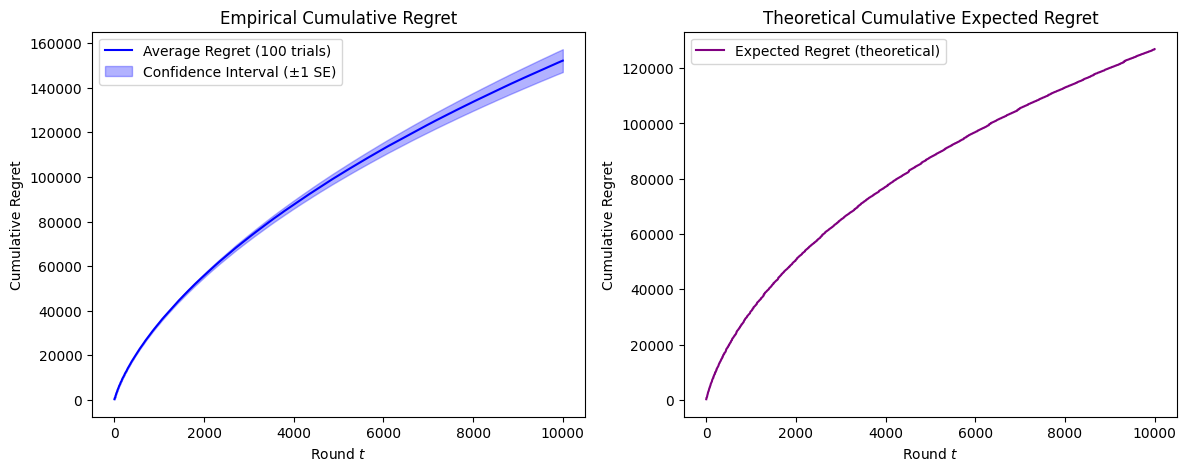

In [155]:
# --- Setup ---

# Init UCB1 parameters
R = (max(P) - cost) * num_of_buyers
K = len(P)

# Init list of n_trials cumulative regrets
regret_array_per_trial = []

# --- Run simulation---

# For each trial, we will generate a new set of valuations
for seed in range(n_trials):
    np.random.seed(seed)
    
    # Generate environment (with new valuations)
    env = PricingEnvironmentSingleProduct(valuations=np.random.normal(loc=value, scale=1.0, size=num_of_buyers), cost=cost)
    
    # Compute realized best reward for this trial
    realized_profit_vector = (P - cost) * np.array([np.sum(valuations >= p) for p in P])
    realized_clairvoyant_rewards = np.full(T, np.max(realized_profit_vector))
    
    # Initialize UCB1 agent
    ucb_agent = UCB1Agent(K, T, range=R)
    agent_rewards = []
    pulled_prices = []

    # Run the simulation for T rounds - Learning...
    for t in range(T):
        arm_index = ucb_agent.pull_arm()
        selected_price = P[arm_index]
        demand, reward = env.round(selected_price)
        ucb_agent.update(reward)
        agent_rewards.append(reward)
        pulled_prices.append(selected_price)
    
    # Cumulative per-trial regret against realized clairvoyant
    regret_array_per_trial.append(np.cumsum(realized_clairvoyant_rewards - agent_rewards))

# Empirical (average) regret over 100 trials
average_regret = np.array(regret_array_per_trial).mean(axis=0)
regret_sd = np.array(regret_array_per_trial).std(axis=0)

# --- Compute theoretical expected regret ---

expected_reward_vector = (P - cost) * expected_demand_vector
best_expected_reward = np.max(expected_reward_vector)
expected_rewards_per_round = expected_reward_vector[[np.where(P == p)[0][0] for p in pulled_prices]]
expected_regret = np.cumsum(best_expected_reward - expected_rewards_per_round)

# --- Combined plot ---
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Empirical regret
axs[0].plot(np.arange(T), average_regret, label='Average Regret (100 trials)', color='blue')
axs[0].fill_between(np.arange(T),
                    average_regret - regret_sd / np.sqrt(n_trials),
                    average_regret + regret_sd / np.sqrt(n_trials),
                    alpha=0.3, color='blue', label='Confidence Interval (±1 SE)')
axs[0].set_title('Empirical Cumulative Regret')
axs[0].set_xlabel('Round $t$')
axs[0].set_ylabel('Cumulative Regret')
axs[0].legend()

# Theoretical expected regret (single run, fixed pulled_prices)
axs[1].plot(expected_regret, label='Expected Regret (theoretical)', color='purple')
axs[1].set_title('Theoretical Cumulative Expected Regret')
axs[1].set_xlabel('Round $t$')
axs[1].set_ylabel('Cumulative Regret')
axs[1].legend()


### Let's see in which arm the algorithm spent more time.

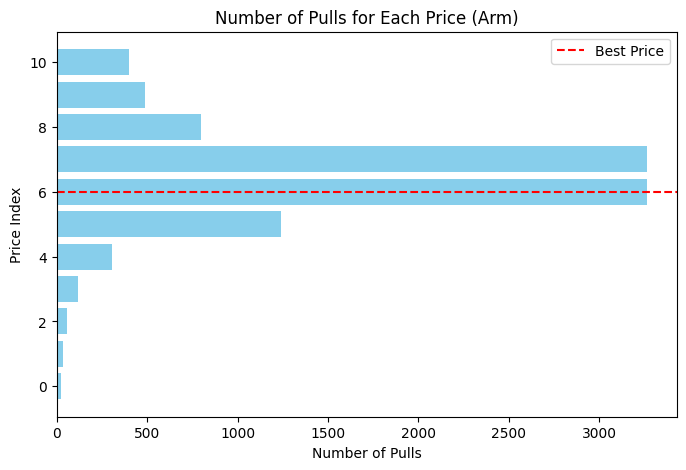

In [156]:
plt.figure(figsize=(8, 5))
plt.barh(np.arange(K), ucb_agent.N_pulls, color='skyblue')
plt.axhline(best_index, color='red', linestyle='--', label='Best Price')
plt.xlabel('Number of Pulls')
plt.ylabel('Price Index')
plt.title('Number of Pulls for Each Price (Arm)')
plt.legend()